In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline

use_last_year_salary = False
with_log_transformation = False

In [2]:
df = pd.read_csv("../data/all_data.csv")

# remove observations with 0 last_year_salary
df[['Salary']] = df[['Salary']].replace(0, np.nan)
if use_last_year_salary:
    df[['last_year_salary']] = df[['last_year_salary']].replace(0, np.nan)
df = df.dropna()

In [3]:
# one-hot encoding for Position
df = df.join(pd.get_dummies(df['Pos']))

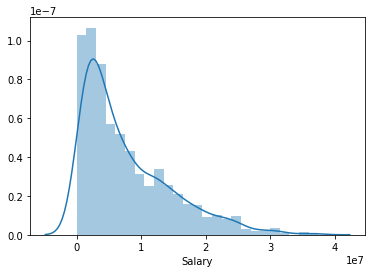

In [4]:
sns.distplot(df['Salary'])

In [5]:
if with_log_transformation:
    df['Salary'] = np.log(df['Salary'])
    df['salary_limit'] = np.log(df['salary_limit'])

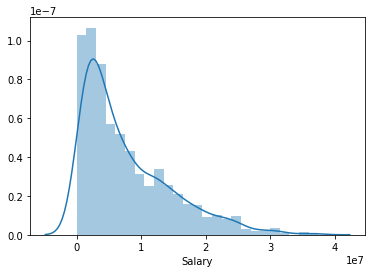

In [6]:
sns.distplot(df['Salary'])

In [7]:

features = ["Age",
            "Game",
            "GS",
            "3P%",
            "FT%",
            "STL",
            "PER",
            "TS%",
            "ORB%",
            "TRB%",
            "AST%",
            "STL%",
            "BLK%",
            "TOV%",
            "USG%",
            "VORP",
            "EFF",
            "GmSc",
            "salary_limit",
            "C",
            "F",
            "G",
            #"F-C",
           ] + (["last_year_salary"] if use_last_year_salary else [])
  
def lr_method():
    df_train, df_test = sklearn.model_selection.train_test_split(df, test_size=0.25)

    lm = linear_model.LinearRegression()
    model = lm.fit(pd.DataFrame(df_train, columns=features),
                   pd.DataFrame(df_train, columns=["Salary"]))
    
    return sqrt(mean_squared_error(
            pd.DataFrame(df_test, columns=["Salary"]),
            lm.predict(pd.DataFrame(df_test, columns=features))
           ))
    #print("test RMSE: ", sqrt(
    #    mean_squared_error(
    #        pd.DataFrame(df_test, columns=["Salary"]),
    #        lm.predict(pd.DataFrame(df_test, columns=features))
    #    )))

results = [lr_method() for _ in range(2000)]


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


mean cv error:  4726817.75547


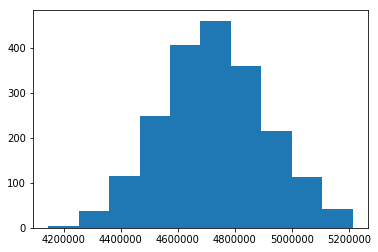

In [8]:
plt.hist(results)
lr_result_mean = np.mean(results)
print("mean cv error: ", lr_result_mean)

In [9]:

# @param msl: minimum number of samples to form a leaf
#             because RF tends to overfit we need to tune this parameter
def runRF(n_e, msl = 1):
    df_train, df_test = sklearn.model_selection.train_test_split(df, test_size=0.25)
    regr = RandomForestRegressor(n_estimators=n_e, n_jobs = -1, min_samples_leaf = msl)
    regr.fit(pd.DataFrame(df_train, columns=features),
             np.ravel(pd.DataFrame(df_train, columns=["Salary"])))
    return sqrt(mean_squared_error(regr.predict(pd.DataFrame(df_test, columns=features)),
                              pd.DataFrame(df_test, columns=['Salary'])
                             ))


此步驟將會耗時約半小時

In [10]:
rf_results1 = [runRF(100) for _ in range(800)]

4545120.10289


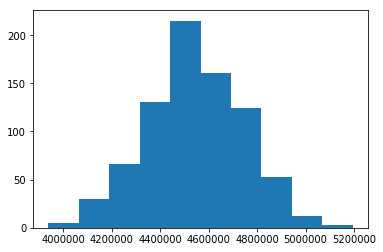

In [11]:
plt.hist(rf_results1)
print(np.mean(rf_results1))

此步驟將會耗時約半小時

In [12]:
rf_results2 = [runRF(100, 2) for _ in range(800)]

4523710.07226


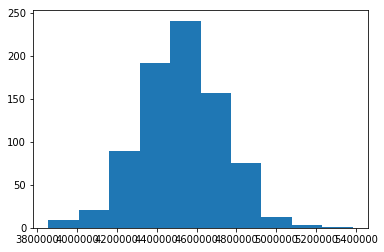

In [13]:
plt.hist(rf_results2)
print(np.mean(rf_results2))

(array([  12.,   51.,  196.,  293.,  177.,   66.,    4.,    1.]),
 array([ 3855322.51576072,  4046612.5942627 ,  4237902.67276468,
         4429192.75126666,  4620482.82976864,  4811772.90827062,
         5003062.98677259,  5194353.06527457,  5385643.14377655]),
 <a list of 8 Patch objects>)

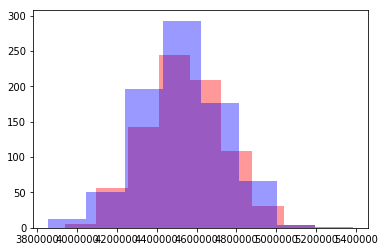

In [14]:
plt.hist(rf_results1, alpha=0.4, color="red", bins=8)
plt.hist(rf_results2, alpha=0.4, color="blue", bins=8)

此步驟將會耗時約一小時

In [15]:
# use different step size for different tree number range. (to save time and to demonstrate the trend)
xvals = []
yvals = []
for i in range(5, 15, 2):
    xvals.append(i)
    yvals.append(np.mean([runRF(i) for _ in range(100)]))
    print(i, " done.")

for i in range(16, 50, 5):
    xvals.append(i)
    yvals.append(np.mean([runRF(i) for _ in range(100)]))
    print(i, " done.")

for i in range(50, 100, 15):
    xvals.append(i)
    yvals.append(np.mean([runRF(i) for _ in range(100)]))
    print(i, " done.")

for i in range(101, 300, 30):
    xvals.append(i)
    yvals.append(np.mean([runRF(i) for _ in range(100)]))
    print(i, " done.")

5  done.
7  done.
9  done.
11  done.
13  done.
16  done.
21  done.
26  done.
31  done.
36  done.
41  done.
46  done.
50  done.
65  done.
80  done.
95  done.
101  done.
131  done.
161  done.
191  done.
221  done.
251  done.
281  done.


number of tree v.s RMSE


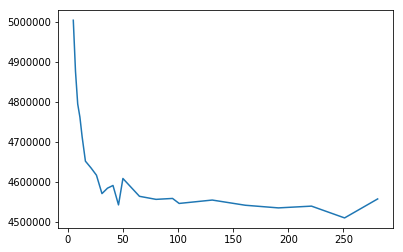

In [17]:
print("number of tree v.s RMSE")
plt.plot(xvals, yvals)

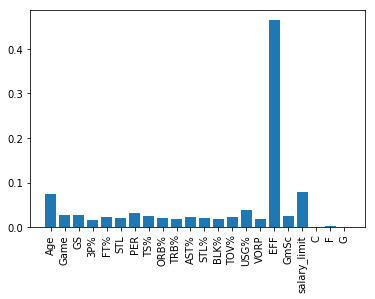

In [18]:
def show_importance():
    regr = RandomForestRegressor(n_estimators=100)
    regr.fit(pd.DataFrame(df, columns=features),
             np.ravel(pd.DataFrame(df, columns=["Salary"])))
    importances = list(regr.feature_importances_)
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    #[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    x_values = list(range(len(importances)))
    plt.bar(x_values, importances, orientation = 'vertical')
    plt.xticks(x_values, features, rotation = 'vertical')
show_importance()

In [19]:

def make_prediction(feature_arr):
    assert len(feature_arr) == len(features)
    X = pd.DataFrame([feature_arr])
    lm = linear_model.LinearRegression()
    model = lm.fit(pd.DataFrame(df, columns=features),
                   pd.DataFrame(df, columns=["Salary"]))
    if with_log_transformation:
        return np.exp(lm.predict(X)[0][0])
    else:
        return (lm.predict(X)[0][0])


In [25]:
# usage example:

make_prediction(pd.DataFrame(df, columns = features).iloc[0].values)

3785619.6042857012